In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import numpy as np


In [6]:
def generate_weather_api_urls(api_key, location, years_back=6):
    base_url = "http://api.worldweatheronline.com/premium/v1/past-weather.ashx"
    urls = []

    # Pobranie biezacej daty
    current_year = datetime.now().year

    # Pętla z ostatnimi 3 latami
    for year in range(current_year - years_back, current_year):
        for month in range(1, 13):  # zakres od stycznia do grudnia
            # definiowanie dnia startowego i koncowego dla kazdego miesiaca
            start_date = datetime(year, month, 1)
            if month == 12:
                end_date = datetime(year + 1, 1, 1) - timedelta(days=1)
            else:
                end_date = datetime(year, month + 1, 1) - timedelta(days=1)
            
            # Formatowanie daty do 'YYYY-MM-DD'
            start_date_str = start_date.strftime('%Y-%m-%d')
            end_date_str = end_date.strftime('%Y-%m-%d')
            
            # Uzupełnianie API
            url = f"{base_url}?key={api_key}&q={location}&format=json&date={start_date_str}&enddate={end_date_str}&tp=24"
            urls.append(url)

    return urls

In [7]:
def extract_weather_data(weather_data):
    extracted_data = []
    
    for day in weather_data:
        date = day["date"]
        maxtempC = day["maxtempC"]
        mintempC = day["mintempC"]
        avgtempC = day["avgtempC"]
        sunHour = day["sunHour"]
        humidity = day["hourly"][0]["humidity"]
        pressure = day["hourly"][0]["pressure"]
        
        extracted_data.append({
            "date": date,
            "maxtempC": maxtempC,
            "mintempC": mintempC,
            "avgtempC": avgtempC,
            "sunHour": sunHour,
            "humidity": humidity,
            "pressure": pressure
        })
    
    return extracted_data

# Nasz klucz oraz wybrana lokalizacja
api_key = "5865dd89353e4ac199861112240706"
location = "London"
urls = generate_weather_api_urls(api_key, location)

all_weather_data = []

for url in urls:
    response = requests.get(url)
    data = response.json()
    weather_data = data["data"]["weather"]
    month_weather_data = extract_weather_data(weather_data)
    all_weather_data.extend(month_weather_data)


df = pd.DataFrame(all_weather_data)
df

,date,maxtempC,mintempC,avgtempC,sunHour,humidity,pressure
0,2018-01-01,8,6,7,5.0,69,999
1,2018-01-02,12,4,8,2.0,81,1005
2,2018-01-03,12,7,9,8.0,60,996
3,2018-01-04,12,7,8,1.0,78,995
4,2018-01-05,9,4,7,8.0,73,995
...,...,...,...,...,...,...,...
2186,2023-12-27,12,7,10,1.0,83,1008
2187,2023-12-28,11,9,11,1.0,72,1006
2188,2023-12-29,10,6,9,7.0,73,1007
2189,2023-12-30,11,6,9,1.0,80,1005


In [8]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [9]:
df['avgtempC'] = df['avgtempC'].astype(int)
df['maxtempC'] = df['maxtempC'].astype(int)
df['mintempC'] = df['mintempC'].astype(int)
df['humidity'] = df['humidity'].astype(int)
df['pressure'] = df['pressure'].astype(int)

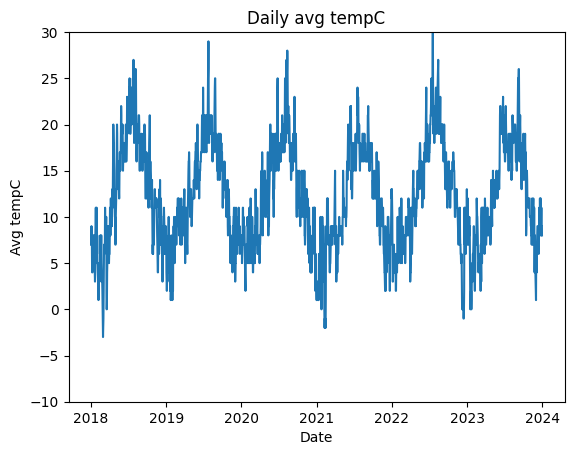

In [10]:
plt.plot(df['avgtempC'])
plt.title('Daily avg tempC')
plt.xlabel('Date')
plt.ylabel('Avg tempC')
plt.ylim(-10,30)
plt.show()

RMSE: 5.511165887467223


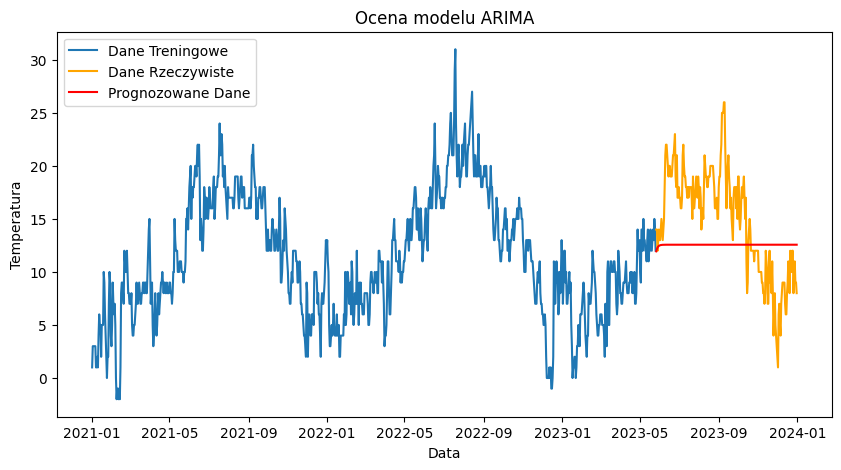

In [24]:
# Wybierzmy kolumnę z temperaturą
temperature_data = df['avgtempC']


# Krok 2: Przygotowanie danych
# Sprawdźmy, czy dane nie mają braków
temperature_data = temperature_data.dropna()

# Podział danych na zestaw treningowy i testowy (np. ostatnie 20% danych to zestaw testowy)
train_size = int(len(temperature_data) * 0.8)
train, test = temperature_data[:train_size], temperature_data[train_size:]

# Krok 3: Budowa modelu auto-SARIMA na danych treningowych
model = auto_arima(train, seasonal=True, m=12)

# Trening modelu
model.fit(train)

# Krok 4: Przewidywanie przyszłej pogody
# Przewidujemy temperaturę na długość zestawu testowego
forecast = model.predict(n_periods=len(test))

# Obliczanie RMSE
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f'RMSE: {rmse}')

# Stwórzmy DataFrame do przewidywań
forecast_df = pd.DataFrame(forecast, index=test.index, columns=['Forecasted_Temperature'])

# Wizualizacja wyników
plt.figure(figsize=(10, 5))
plt.plot(train, label='Dane Treningowe')
plt.plot(test, label='Dane Rzeczywiste', color='orange')
plt.plot(forecast_df, label='Prognozowane Dane', color='red')
plt.legend()
plt.title('Ocena modelu ARIMA')
plt.xlabel('Data')
plt.ylabel('Temperatura')
plt.show()